# ${\cal M}^*_\%$ contours in the $m$-$e_0$ plane and $\eta$-$e_0$ plane

In [ ]:
# check which lalsimulation is being used
import lalsimulation as lal
lal.__file__

'/Users/phurailatpamhemantakumar/phd/mypackages/lalsuite-install/lib/python3.10/site-packages/lalsimulation/__init__.py'

In [2]:
import os
import pycbc
from pycbc.filter.matchedfilter import match
from pycbc.types.frequencyseries import FrequencySeries
import numpy as np
import bilby
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
%matplotlib inline

In [10]:
Gamma = 0.5772156649015329
Pi = np.pi
MTSUN_SI = 4.925491025543576e-06

def findchirp_chirptime(m1, m2, fmin):
    """
    Time taken from f_min to f_lso (last stable orbit). 3.5PN in fourier phase considered.

    Parameters
    ----------
    m1 : `float`
        Mass of the first body in solar masses.
    m2 : `float`
        Mass of the second body in solar masses.
    fmin : `float`
        Lower frequency cutoff.

    Returns
    -------
    chirp_time : float
        Time taken from f_min to f_lso (last stable orbit frequency).
    """

    # variables used to compute chirp time
    m = m1 + m2
    eta = m1 * m2 / m / m
    c0T = c2T = c3T = c4T = c5T = c6T = c6LogT = c7T = 0.0

    c7T = Pi * (
        14809.0 * eta * eta / 378.0 - 75703.0 * eta / 756.0 - 15419335.0 / 127008.0
    )

    c6T = (
        Gamma * 6848.0 / 105.0
        - 10052469856691.0 / 23471078400.0
        + Pi * Pi * 128.0 / 3.0
        + eta * (3147553127.0 / 3048192.0 - Pi * Pi * 451.0 / 12.0)
        - eta * eta * 15211.0 / 1728.0
        + eta * eta * eta * 25565.0 / 1296.0
        + eta * eta * eta * 25565.0 / 1296.0
        + np.log(4.0) * 6848.0 / 105.0
    )
    c6LogT = 6848.0 / 105.0

    c5T = 13.0 * Pi * eta / 3.0 - 7729.0 * Pi / 252.0

    c4T = 3058673.0 / 508032.0 + eta * (5429.0 / 504.0 + eta * 617.0 / 72.0)
    c3T = -32.0 * Pi / 5.0
    c2T = 743.0 / 252.0 + eta * 11.0 / 3.0
    c0T = 5.0 * m * MTSUN_SI / (256.0 * eta)

    # This is the PN parameter v evaluated at the lower freq. cutoff
    xT = np.power(Pi * m * MTSUN_SI * fmin, 1.0 / 3.0)
    x2T = xT * xT
    x3T = xT * x2T
    x4T = x2T * x2T
    x5T = x2T * x3T
    x6T = x3T * x3T
    x7T = x3T * x4T
    x8T = x4T * x4T

    # Computes the chirp time as tC = t(v_low)
    # tC = t(v_low) - t(v_upper) would be more
    # correct, but the difference is negligble.
    return (
        c0T
        * (
            1
            + c2T * x2T
            + c3T * x3T
            + c4T * x4T
            + c5T * x5T
            + (c6T + c6LogT * np.log(xT)) * x6T
            + c7T * x7T
        )
        / x8T
    )

In [18]:
time_of_event = 1126259642.413
post_trigger_duration = 1.
duration = 309.0
analysis_start = time_of_event + post_trigger_duration - duration
sampling_frequency = 2048.
f_min = 20.0

injection_parameters = {'mass_1':1.61, 'mass_2':1.18, 'eccentricity':0.1, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,}
1.61+1.18, 1.18/1.61

############# TF2Ecck waveform model ################
waveform_arguments1 = dict(waveform_approximant='TaylorF2Ecck',
                          reference_frequency=f_min, minimum_frequency=f_min)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments1)

############# TF2Ecc waveform model ################
waveform_arguments3 = dict(waveform_approximant='TaylorF2Ecc',
                          reference_frequency=f_min, minimum_frequency=f_min, pn_phase_order=6, pn_tidal_order=0)

waveform_generator3 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments3)

ifos = bilby.gw.detector.InterferometerList(['L1'])
ifos.set_strain_data_from_zero_noise(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=analysis_start)

16:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
16:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


## Contour plot panels showing mismatch ${\cal M}^*_\%$ contours as a function of $m$ Vs $e_0$ ($q$ fixed)

In [19]:
def find_matchvalues(input_arguments):
    i = input_arguments[0]
    size = input_arguments[1]
    waveform_generator1 = input_arguments[2]
    waveform_generator2 = input_arguments[3]
    mass_ratio = input_arguments[4]
    fmin = 20.0
    
    match_array_ab = np.zeros(size)
    mtot_arr = np.linspace(2., 6.0, size)
    e0_arr = np.linspace(0.01, 0.1, size)
    e0 = e0_arr[i]

    for j in range(size):
        mtot_ = mtot_arr[j]
        mass_1_ = mtot_/(1+mass_ratio)
        mass_2_ = mass_1_*mass_ratio
        injection_parameters = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':e0, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,}

        safety = 1.2
        approx_duration = safety * findchirp_chirptime(mass_1_, mass_2_, fmin)
        duration = np.ceil(approx_duration + 2.0)

        if duration < 4:
            duration = 4.0
        
        polas_a = waveform_generator1.frequency_domain_strain(parameters = injection_parameters) # TF2Ecck
        polas_b = waveform_generator2.frequency_domain_strain(parameters = injection_parameters) # TF2Ecch
        arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
        arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
        psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)
        f_max = 1024.
        match_array_ab[j]=match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max)[0]   
    return i, (1-match_array_ab)*100

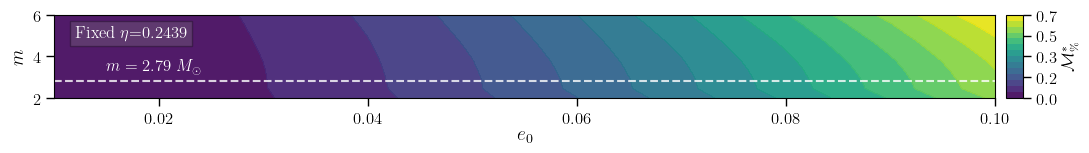

In [20]:
size = 10
q = 0.73
eta = q/(1+q)**2
npool =8
waveform_generatorb_list = [
    waveform_generator3, # TF2Ecc
    ]
waveform_generatora = waveform_generator1 # TF2Ecck

for waveform_generatorb in waveform_generatorb_list:

    if waveform_generatorb.waveform_arguments['waveform_approximant'] == 'TaylorF2Ecch':
        vs = 'EcckVsEcch'
        wide = 3.86 
    elif waveform_generatorb.waveform_arguments['waveform_approximant'] == 'TaylorF2Ecc':
        vs = 'EcckVsEcc'
        wide = 3.81
    elif waveform_generatorb.waveform_arguments['waveform_approximant'] == 'TaylorF2':
        vs = 'EcckVsTF2'
        wide = 4
    else:
        raise ValueError

    filename = f'mismatchvalues_{vs}_fixed_q.npy'
    plot_filename = f'mismatchvalues_{vs}_fixed_q_EcckVsEcc.pdf'
    create_new = False

    idx_ = np.arange(size)
    size_arr = np.full(size, size)
    q_arr = np.full(size, q)
    waveform_generatora_arr = np.full(size, waveform_generatora)
    waveform_generatorb_arr = np.full(size, waveform_generatorb)
    input_arguments = np.array([idx_, size_arr, waveform_generatora_arr, waveform_generatorb_arr, q_arr], dtype=object).T

    mismatch_array_ab = np.zeros((size, size))
    if not os.path.exists(filename) or create_new:
        with Pool(processes=npool) as pool:
            for result in tqdm(
                pool.imap_unordered(find_matchvalues, input_arguments),
                total=size,
            ):
                i, mismatch_array = result
                mismatch_array_ab[i] = mismatch_array
        np.save(filename, mismatch_array_ab)
    else:
        mismatch_array_ab = np.load(filename)

    x = np.linspace(2.0, 6.0, size) # total_mass
    y = np.linspace(0.01, 0.1, size) # e0
    X, Y = np.meshgrid(x, y)
    Z = mismatch_array_ab

    import matplotlib.pyplot as plt
    import numpy as np  # Make sure you import numpy

    # Enable LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 12,
    })

    # Sample data setup
    fig, ax = plt.subplots(figsize=(12, 1.7))

    # Define a smaller number of contour levels
    levels = np.linspace(Z.min(), Z.max(), 15)  # 5 levels

    # Filled contour plot using a dark colormap
    cp = ax.contourf(Y, X, Z, levels=levels, cmap='viridis', alpha=0.95)

    plt.xlabel(r'$e_0$', fontsize=14, labelpad=0.0)
    if vs == 'EcckVsTF2':
        plt.ylabel(r'$m$ ($M_\odot$)', fontsize=14)
    label = None
    if vs == 'EcckVsEcch':
        label=r'${\cal M}^*_{\%}$'
    plt.ylabel(r'$m$', fontsize=14)
    label=r'${\cal M}^*_{\%}$'
        
    plt.colorbar(cp, label=label, 
                format='%.1f', 
                # show only 5 levels ticks
                boundaries=np.linspace(Z.min(), Z.max(), 5),
                ticks=np.linspace(Z.min(), Z.max(), 5),
                aspect=5, pad=0.01)
    # add extra legend
    ax.text(0.012, 4.9, rf'Fixed $\eta$={eta:.4}', color='w', fontsize=12, alpha=1.0, zorder=5, bbox=dict(facecolor='gray', alpha=0.3))

    # horizontal line
    ax.axhline(2.79, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(0.015, 3.3, r'$m=2.79$ $M_\odot$', color='w', fontsize=12, alpha=1.0, zorder=5)

    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
    plt.tight_layout()
    plt.savefig(plot_filename)

## Contour plot panels showing mismatch ${\cal M}^*_\%$ contours as a function of $\eta$ Vs $e_0$ ($m$ fixed)

In [21]:
def find_matchvalues(input_arguments):
    i = input_arguments[0]
    size = input_arguments[1]
    waveform_generator1 = input_arguments[2]
    waveform_generator2 = input_arguments[3]
    mtot = input_arguments[4]
    fmin = 20.0
    
    match_array_ab = np.zeros(size)
    eta = np.linspace(0.1875, 0.25, size)
    sqrt_term = np.sqrt(1 - 4 * eta)
    q_arr = (1 - 2 * eta - sqrt_term) / (2 * eta)
    e0_arr = np.linspace(0.01, 0.1, size)
    e0 = e0_arr[i]

    for j in range(size):
        mass_ratio = q_arr[j]
        mass_1_ = mtot/(1+mass_ratio)
        mass_2_ = mass_1_*mass_ratio
        injection_parameters = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':e0, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0., 'geocent_time':1246527184.169434, 'ra':3.45, 'dec':-0.41,}

        safety = 1.2
        approx_duration = safety * findchirp_chirptime(mass_1_, mass_2_, fmin)
        duration = np.ceil(approx_duration + 2.0)

        if duration < 4:
            duration = 4.0
        
        polas_a = waveform_generator1.frequency_domain_strain(parameters = injection_parameters) # TF2Ecck
        polas_b = waveform_generator2.frequency_domain_strain(parameters = injection_parameters) # TF2Ecch
        arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
        arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
        psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)

        f_max = 1024.
        match_array_ab[j]=match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max)[0]
        
    return i, (1-match_array_ab)*100

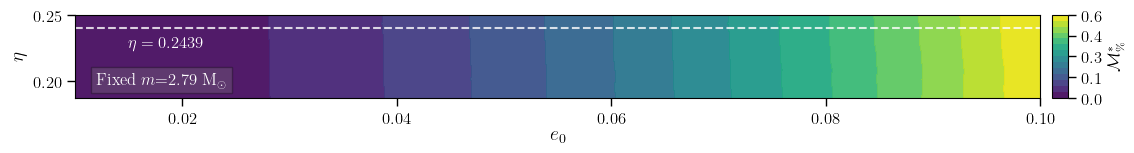

In [22]:
size = 10
mtot = 2.79 # M_sun
npool =8
waveform_generatorb_list = [
    waveform_generator3, # TF2Ecc
    ]
waveform_generatora = waveform_generator1 # TF2Ecck

for waveform_generatorb in waveform_generatorb_list:
    if waveform_generatorb.waveform_arguments['waveform_approximant'] == 'TaylorF2Ecch':
        vs = 'EcckVsEcch'
        wide = 3.86 
    elif waveform_generatorb.waveform_arguments['waveform_approximant'] == 'TaylorF2Ecc':
        vs = 'EcckVsEcc'
        wide = 3.81
    elif waveform_generatorb.waveform_arguments['waveform_approximant'] == 'TaylorF2':
        vs = 'EcckVsTF2'
        wide = 4
    else:
        raise ValueError

    filename = f'mismatchvalues_{vs}_fixed_mtot.npy'
    plot_filename = f'mismatchvalues_{vs}_fixed_mtot_EcckVsEcc.pdf'
    create_new = False

    idx_ = np.arange(size)
    size_arr = np.full(size, size)
    mtot_arr = np.full(size, mtot)
    waveform_generatora_arr = np.full(size, waveform_generatora)
    waveform_generatorb_arr = np.full(size, waveform_generatorb)
    input_arguments = np.array([idx_, size_arr, waveform_generatora_arr, waveform_generatorb_arr, mtot_arr], dtype=object).T

    from multiprocessing import Pool
    import os

    mismatch_array_ab = np.zeros((size, size))
    if not os.path.exists(filename) or create_new:
        with Pool(processes=npool) as pool:
            for result in tqdm(
                pool.imap_unordered(find_matchvalues, input_arguments),
                total=size,
            ):
                i, mismatch_array = result
                mismatch_array_ab[i] = mismatch_array
        np.save(filename, mismatch_array_ab)
    else:
        mismatch_array_ab = np.load(filename)

    x = np.linspace(0.1875, 0.25, size) # total_mass
    y = np.linspace(0.01, 0.1, size) # e0
    X, Y = np.meshgrid(x, y)
    Z = mismatch_array_ab

    # Enable LaTeX rendering
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "font.size": 12,
    })

    # Sample data setup
    fig, ax = plt.subplots(figsize=(12.5, 1.7))

    # Define a smaller number of contour levels
    levels = np.linspace(Z.min(), Z.max(), 15)  # 5 levels

    # Filled contour plot using a dark colormap
    cp = ax.contourf(Y, X, Z, levels=levels, cmap='viridis', alpha=0.95)

    plt.xlabel(r'$e_0$', fontsize=14, labelpad=0.0)
    if vs == 'EcckVsTF2':
        plt.ylabel(r'$\eta$', fontsize=14)

    label = None
    if vs == 'EcckVsEcch':
        label=r'${\cal M}^*_{\%}$' 

    # overwrite the label
    label=r'${\cal M}^*_{\%}$' 
    plt.ylabel(r'$\eta$', fontsize=14)

    plt.colorbar(cp, label=label, 
                format='%.1f', 
                # show only 5 levels ticks
                boundaries=np.linspace(Z.min(), Z.max(), 5),
                ticks=np.linspace(Z.min(), Z.max(), 5),
                aspect=5, pad=0.01)
    # add extra legend
    ax.text(0.012, 0.198, rf'Fixed $m$={mtot} M$_\odot$', color='w', fontsize=12, alpha=1.0, zorder=5, bbox=dict(facecolor='gray', alpha=0.3))

    #horizontal line
    ax.axhline(0.24, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(0.015, 0.225, r'$\eta=0.2439$', color='w', fontsize=12, alpha=1.0, zorder=5)

    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)
    plt.tight_layout()
    plt.savefig(plot_filename)